In [18]:
import os
import sys
from pathlib import Path
# Make sure all code is in the PATH.
sys.path.append("../src/")

In [19]:
import functools
import lzma
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numba as nb
import numpy as np
import pandas as pd
import pyteomics.mgf
import seaborn as sns
import tqdm.notebook as tqdm
from matplotlib.colors import LogNorm


In [20]:
# Plot styling.
plt.style.use(["seaborn-white", "seaborn-paper"])
plt.rc("font", family="sans-serif")
sns.set_palette(["#9e0059", "#6da7de", "#ee266d", "#dee000", "#eb861e"])
sns.set_context("paper")

## Finished setup, start plotting

In [21]:
# filename = "results/gnps_lib_sqrt_True_500000pairs_6min_signals_200maxdelta.parquet"
filename = "results/gnps_lib_sqrt_False_500000pairs_6min_signals_200maxdelta.parquet"
# filename = "results/BILELIB19_oxygen_sqrt_False_500000pairs_6min_signals_15i9949specific_delta.parquet"
# filename = "results/BILELIB19_as_exchange_sqrt_False_500000pairs_6min_signals_200maxdelta_8mods.parquet"
# filename = "results/BILELIB19_bile_conjugates_sqrt_False_500000pairs_6min_signals_200maxdelta_5mods.parquet"

# use filename to identify exported files
analysis_id = Path(filename).stem

similarities = pd.read_parquet(filename)
similarities.head(5)

,id1,id2,delta_mz,cos_score,cos_matched_intensity,cos_max_contribution,cos_n_greq_2p,cos_matches,mod_score,mod_matched_intensity,mod_max_contribution,mod_n_greq_2p,mod_matches,nl_score,nl_matched_intensity,nl_max_contribution,nl_n_greq_2p,nl_matches
0,CCMSLIB00005730147,CCMSLIB00000085610,48.132,1.946173e-02,0.898507,1.278510e-02,0,79,0.019649,0.923292,0.012785,0,87,0.001722,0.597913,0.000489,0,49
1,CCMSLIB00005885031,CCMSLIB00005738388,111.079,2.668020e-07,0.007128,2.668020e-07,0,1,0.000217,0.042221,0.000151,0,3,0.000217,0.033056,0.000151,0,2
2,CCMSLIB00005883869,CCMSLIB00005747055,169.089,1.417969e-02,0.200179,1.081171e-02,0,25,0.014210,0.227677,0.010812,0,34,0.000035,0.050863,0.000012,0,12
3,CCMSLIB00005769766,CCMSLIB00000080109,171.102,1.974226e-06,0.001501,1.974226e-06,0,1,0.000074,0.010484,0.000072,0,2,0.000072,0.008965,0.000072,0,1
4,CCMSLIB00006687604,CCMSLIB00006706651,3.850,4.168943e-07,0.001180,4.168943e-07,0,1,0.974225,0.982718,0.973935,1,4,0.974225,0.895249,0.973935,1,3


In [22]:
similarities = similarities[(similarities["cos_score"]>0) & (similarities["mod_score"]>0) & (similarities["nl_score"]>0)]
len(similarities)

209987

In [23]:
total = len(similarities)
stats = {
    'total': total,
    'cos higher': len(similarities[similarities["cos_score"]>similarities["nl_score"]])/ total,
    'nl higher': len(similarities[similarities["cos_score"]<similarities["nl_score"]])/ total
}
print(stats)

{'total': 209987, 'cos higher': 0.414716149094944, 'nl higher': 0.5852648021067971}


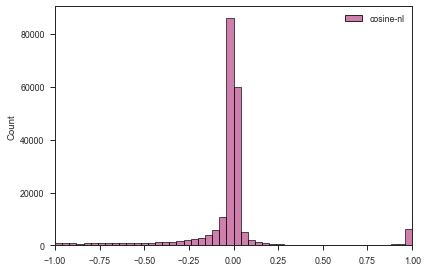

In [24]:
df = pd.DataFrame()
# df['cosine'] = similarities['cosine']
# df['neutral_loss'] = similarities['neutral_loss']
df['cosine-nl'] = similarities['cos_score'] - similarities['nl_score']
ax = sns.histplot(data=df, binwidth=0.04)
ax.set_xlim((-1,1))

plt.savefig("results/img/diff_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

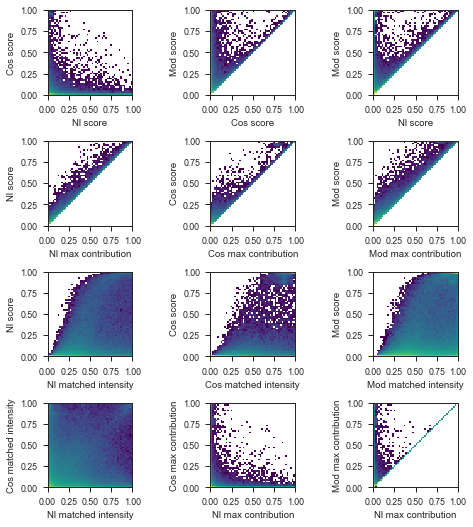

In [25]:
plots = [
        ["nl_score", "cos_score"],
        ["cos_score", "mod_score"],
        ["nl_score", "mod_score"],
        ["nl_max_contribution", "nl_score"],
        ["cos_max_contribution", "cos_score"],
        ["mod_max_contribution", "mod_score"],
        ["nl_matched_intensity", "nl_score"],
        ["cos_matched_intensity", "cos_score"],
        ["mod_matched_intensity", "mod_score"],
        ["nl_matched_intensity", "cos_matched_intensity"],
        ["nl_max_contribution", "cos_max_contribution"],
        ["nl_max_contribution", "mod_max_contribution"],
    ]

fig, axes = plt.subplots(4, 3, figsize=(7, 12 / 1.618))

bins = 50
tick_locators = mticker.FixedLocator(np.arange(0, bins + 1, bins / 4))
tick_labels = np.asarray([f"{a:.2f}" for a in np.arange(0, 1.01, 0.25)])

for i, ax in enumerate(axes.flatten()):
    if i >= len(plots):
        break

    (xlabel, ylabel) = plots[i]
    hist, _, _ = np.histogram2d(
        similarities[xlabel],
        similarities[ylabel],
        bins=bins,
        range=[[0, 1], [0, 1]],
    )
    heatmap = sns.heatmap(
        np.rot90(hist),
        cmap="viridis",
        cbar=False,
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=ax,
        norm=LogNorm(),
    )
    ax.yaxis.set_major_locator(tick_locators)
    ax.set_yticklabels(tick_labels[::-1])
    ax.xaxis.set_major_locator(tick_locators)
    ax.set_xticklabels(tick_labels)
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)
    ax.set_xlabel(xlabel.replace("_", " ").capitalize())
    ax.set_ylabel(ylabel.replace("_", " ").capitalize())


plt.tight_layout()

plt.savefig("results/img/score_contributions_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

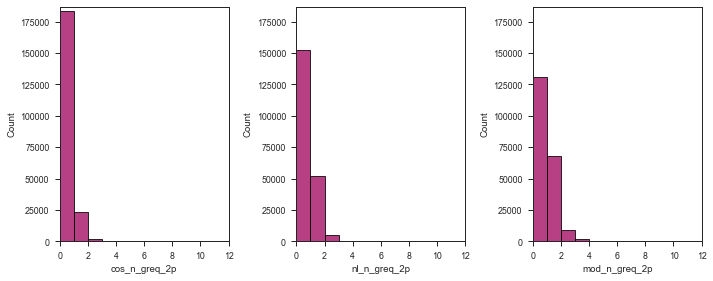

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

xlabels = ["cos_n_greq_2p","nl_n_greq_2p","mod_n_greq_2p"]
max_x = similarities[["cos_n_greq_2p","nl_n_greq_2p","mod_n_greq_2p"]].max().max()
max_y = max(similarities[xlabel].value_counts()[0] for xlabel in xlabels) * 1.02

for i, ax in enumerate(axes.flatten()):
    xlabel = xlabels[i]

    hist = sns.histplot(data=similarities, x=xlabel, binwidth=1, ax= ax)
    # for _, spine in hist.spines.items():
    #     spine.set_visible(True)
    # ax.set_xlabel(xlabel.replace("_", " ").capitalize())
    # ax.set_ylabel(ylabel.replace("_", " ").capitalize())

    ax.set_xlim((0,max_x))
    ax.set_ylim((0,max_y))

plt.tight_layout()

plt.savefig("results/img/greater_2p_signals_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
g = sns.pairplot(similarities, kind="hist",
             vars=["cos_score", "nl_score", "mod_score", "cos_max_contribution", "nl_max_contribution"])
for axes in g.axes:
    for a in axes:
        a.set_xlim((0,1))
        a.set_ylim((0,1))

plt.savefig("results/img/pair_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()